# Combining it all

Here we will combine the approaches of all the past inversions. Here our the main steps we will follow:

1) create a true topography and synthetic observed gravity
2) create a starting model from the points of known topography (`constraints`) 
3) calculate a starting misfit
4) perform a damping parameter cross validation to determine the optimal damping value
5) use this damping value to perform a cross validation to find the optimal density and reference level values
6) create the weighting grid to help the inversion adhere to the constraints
7) perform a full final inversion constrained by the `weighting grid`, using the optimal damping, density, and reference level values. 


## Import packages

In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import itertools
import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import utils as polar_utils
from tqdm.autonotebook import tqdm

from invert4geom import cross_validation, inversion, plotting, synthetic, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Create synthetic topography and observed gravity data

### True topography

In [3]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

## 2) Create starting topography from constraints

Sample the starting topography at 10 random locations and regrid with those sampled values. This sumulates only knowing the depth to this topography at 10 boreholes.

In [4]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

# re-sample the starting topography at the constraint points to see how the gridded did
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE at the constraints between the starting and true topography: {rmse:.2f} m")

RMSE at the constraints between the starting and true topography: 0.14 m


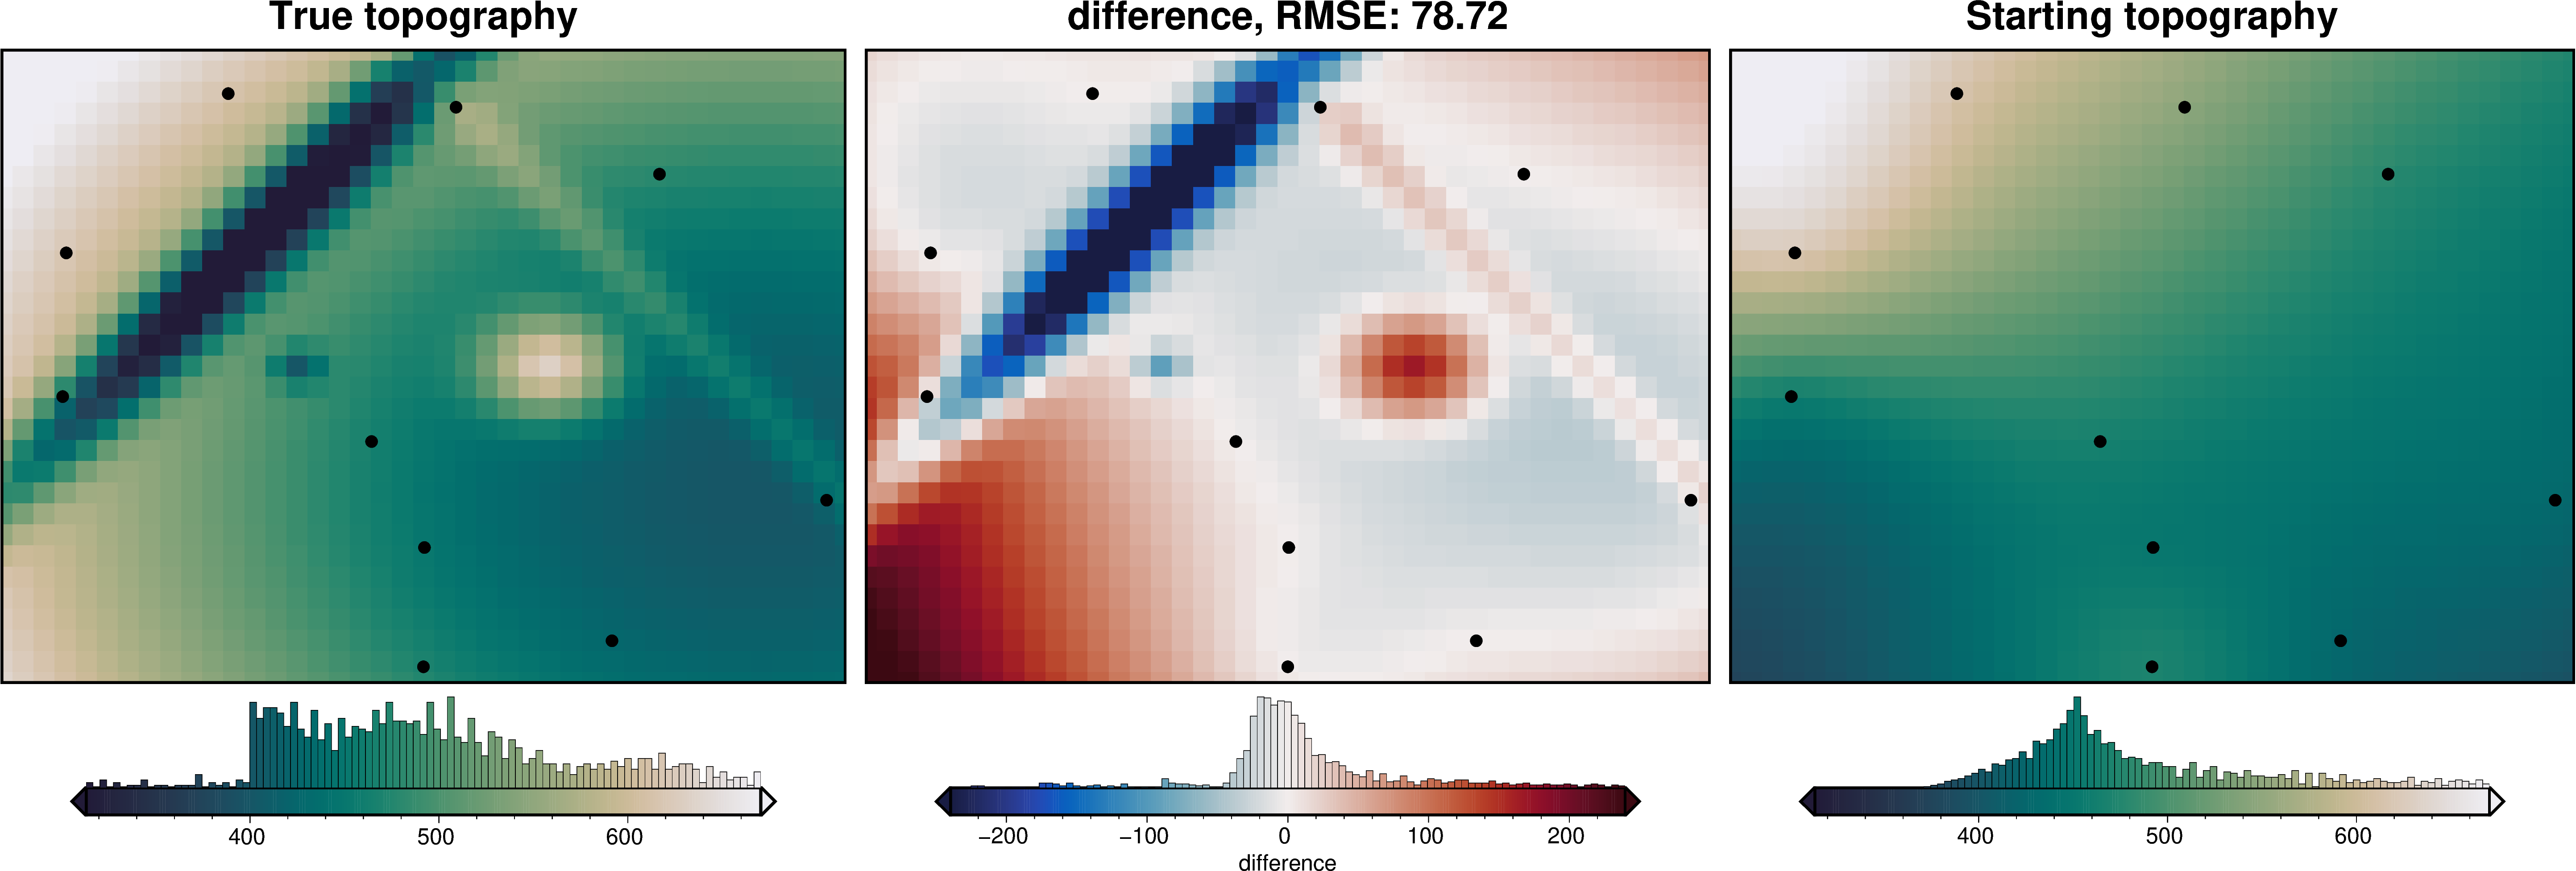

In [5]:
_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

### Prism layer

In [6]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()
print(f"zref: {zref:.2f} m")

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

zref: 492.27 m


### Forward gravity of prism layer

In [7]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


In [8]:
# resample to half spacing
grav_df = cross_validation.resample_with_test_points(spacing, grav_df, region)
grav_df

,northing,easting,test,upward,grav
0,0.0,0.0,False,1000.0,9.534643
1,0.0,500.0,True,1000.0,10.063805
2,0.0,1000.0,False,1000.0,10.422834
3,0.0,1500.0,True,1000.0,10.284459
4,0.0,2000.0,False,1000.0,9.949973
...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438
4937,30000.0,38500.0,True,1000.0,3.346051
4938,30000.0,39000.0,False,1000.0,3.300721
4939,30000.0,39500.0,True,1000.0,3.104991


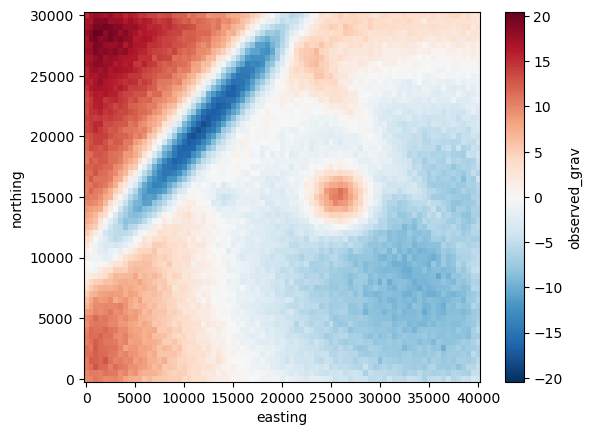

In [9]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

## 3) Calculate starting gravity misfit 
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

We don't know the optimal values for the density contrast or the reference level, so we will make a guess at appropiate values for the starting model.

In [10]:
# the true zref value is 492 m
zref = 300

# the true density contrast is 2669 kg/m3
density_contrast = 2300

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,test,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,False,1000.0,9.534643,9.600445,3.933482,5.666963,0,5.666963
1,0.0,500.0,True,1000.0,10.063805,10.000689,4.571924,5.428765,0,5.428765
2,0.0,1000.0,False,1000.0,10.422834,10.745982,4.917636,5.828346,0,5.828346
3,0.0,1500.0,True,1000.0,10.284459,10.339846,5.153018,5.186827,0,5.186827
4,0.0,2000.0,False,1000.0,9.949973,9.685075,5.341384,4.343691,0,4.343691
...,...,...,...,...,...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438,4.215689,11.627480,-7.411791,0,-7.411791
4937,30000.0,38500.0,True,1000.0,3.346051,2.857467,11.331788,-8.474321,0,-8.474321
4938,30000.0,39000.0,False,1000.0,3.300721,4.021803,10.920762,-6.898958,0,-6.898958
4939,30000.0,39500.0,True,1000.0,3.104991,2.344870,10.246157,-7.901287,0,-7.901287


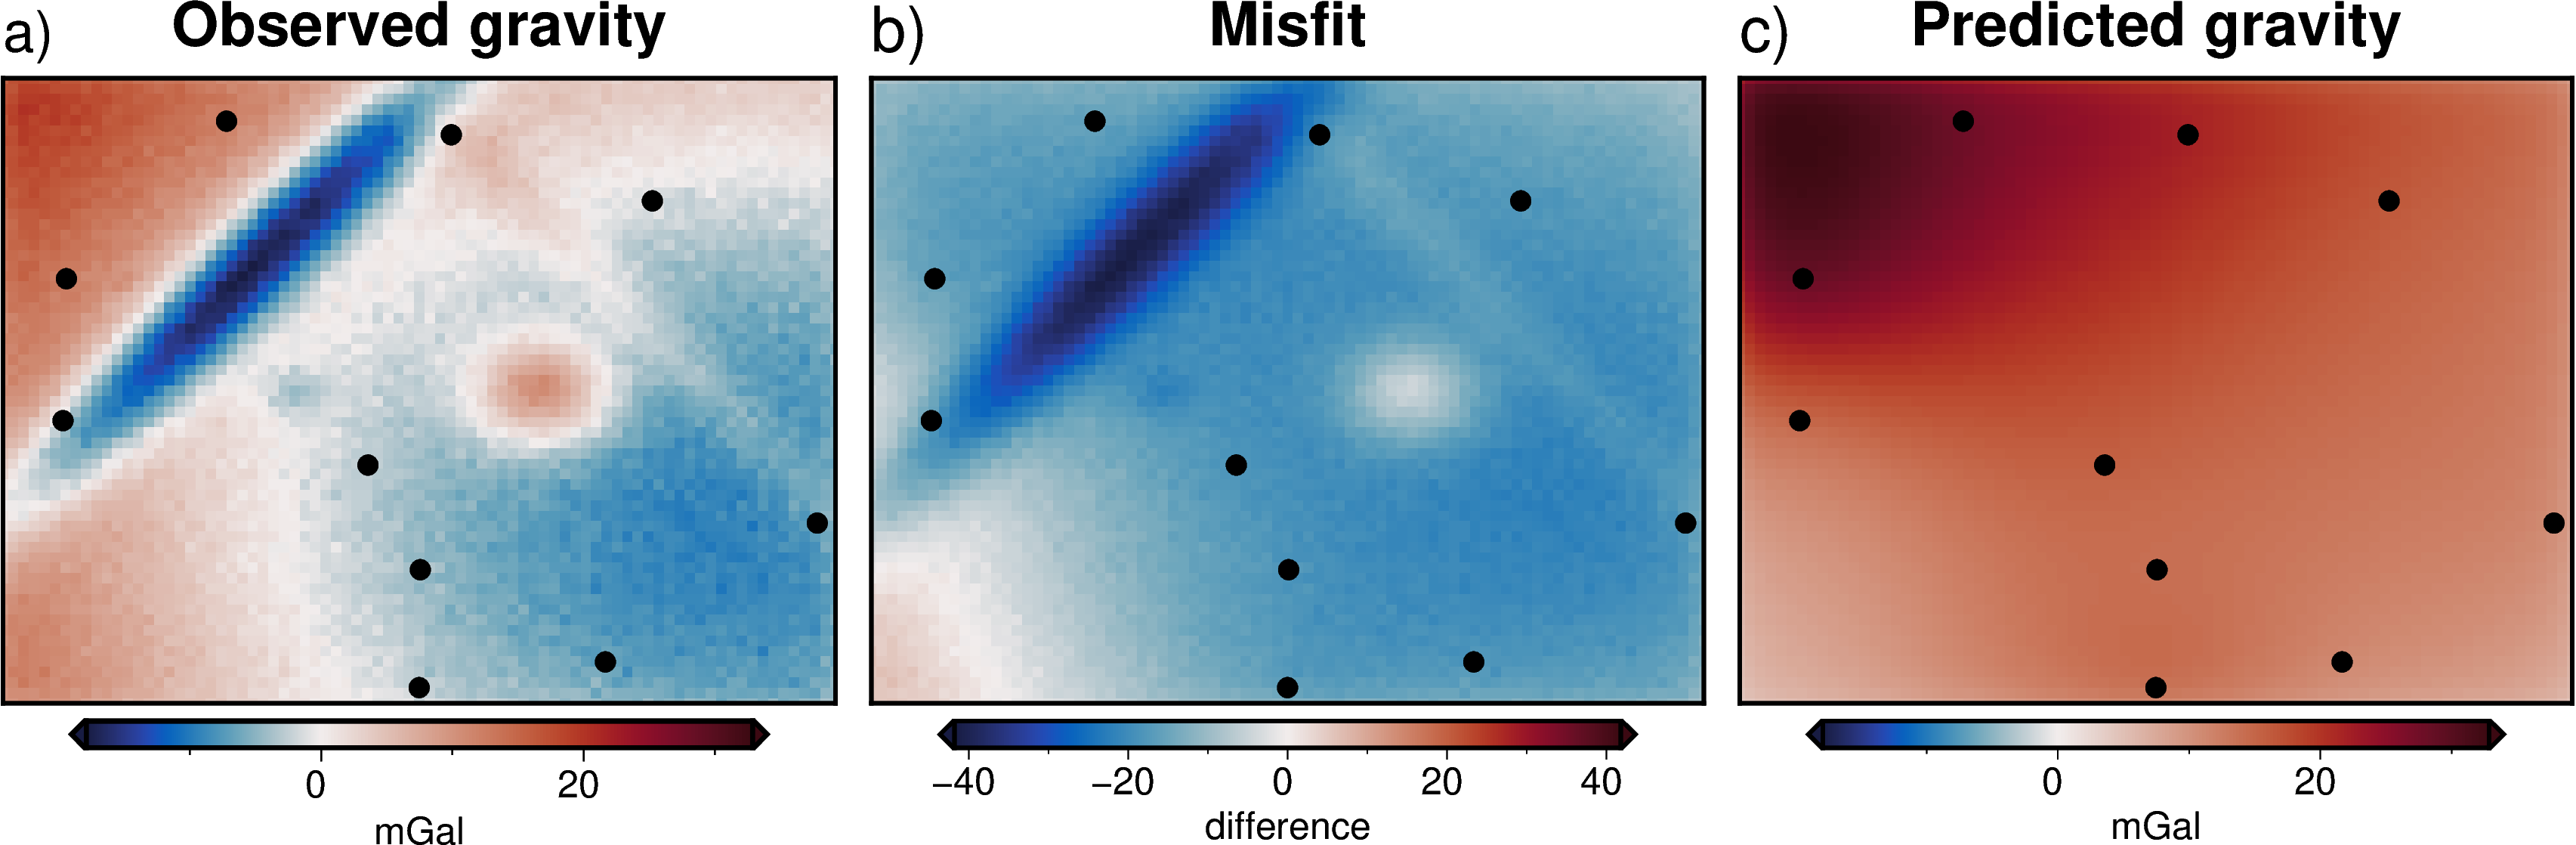

In [11]:
_ = polar_utils.grd_compare(
    grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav,
    grav_df.set_index(["northing", "easting"]).to_xarray().starting_grav,
    # plot_type="xarray",
    fig_height=7,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Predicted gravity",
    # robust=True,
    # hist=True,
    cmap="balance+h0",
    inset=False,
    verbose="q",
    title="Misfit",
    rmse_in_title=False,
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    cbar_label="mGal",
    subplot_labels=True,
)

## 4) Damping parameter cross validation

In [12]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "observed_grav",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    "zref": zref,
    "density_contrast": density_contrast,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# set which damping parameters to include
dampings = np.logspace(-3, 0, 12)

best_damping, _, _, scores = cross_validation.grav_optimal_parameter(
    training_data=grav_df[grav_df.test == False],  # noqa: E712
    testing_data=grav_df[grav_df.test == True],  # noqa: E712
    param_to_test=("solver_damping", dampings),
    progressbar=True,
    # plot_grids=True,
    plot_cv=False,
    verbose=True,
    **kwargs,
)

Parameter values:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:root:Parameter value: 0.001 -> Score: 3.860537617339199
INFO:root:Parameter value: 0.001873817422860383 -> Score: 0.9267845206469868
INFO:root:Parameter value: 0.003511191734215131 -> Score: 0.6712883350267852
INFO:root:Parameter value: 0.006579332246575682 -> Score: 0.6532895278512788
INFO:root:Parameter value: 0.012328467394420659 -> Score: 0.6346517508526428
INFO:root:Parameter value: 0.02310129700083159 -> Score: 0.6084247560141067
INFO:root:Parameter value: 0.04328761281083057 -> Score: 0.6056207983231817
INFO:root:Parameter value: 0.08111308307896868 -> Score: 0.5940127470034084
INFO:root:Parameter value: 0.1519911082952933 -> Score: 0.6275250145203626
INFO:root:Parameter value: 0.2848035868435799 -> Score: 2.1442529596543607
INFO:root:Parameter value: 0.5336699231206307 -> Score: 9.280702486830197
INFO:root:Parameter value: 1.0 -> Score: 17.996145347086234
INFO:root:Best score of 0.5940127470034084 with parameter value=0.08111308307896868


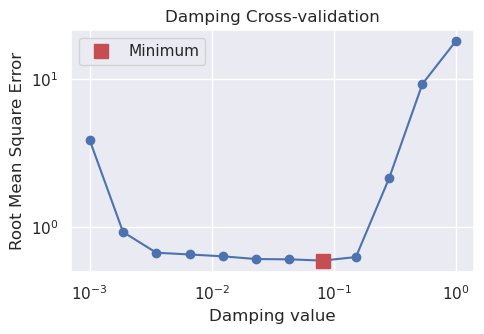

In [13]:
# Compare the scores and the damping values
plotting.plot_cv_scores(
    scores,
    dampings,
    param_name="Damping",
    logx=True,
    logy=True,
)

## 5) Cross validation for density and reference level

We will use the optimal damping value found in the previous step.

In [15]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "observed_grav",
    "deriv_type": "annulus",
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# set which zref values to include
zrefs = np.linspace(400, 600, 8)

# set which density contrasts to include
density_contrasts = np.linspace(2400, 3000, 8)

# set the optimal damping value
kwargs["solver_damping"] = best_damping

# create all possible combinations of zref and density contrast
parameter_pairs = list(itertools.product(zrefs, density_contrasts))

# we don't need the testing gravity data anymore
grav_df = grav_df[grav_df.test == False].copy()  # noqa: E712

# run inversions and collect scores
scores = []
for zref, density_contrast in tqdm(parameter_pairs, desc="Parameter pairs"):
    # re-calculate density grid with new density contrast
    density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

    # create layer of prisms
    starting_prisms = utils.grids_to_prisms(
        starting_topography,
        zref,
        density=density,
    )

    # calculate forward gravity of starting prism layer
    grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
        coordinates=(
            grav_df.easting,
            grav_df.northing,
            grav_df.upward,
        ),
        field="g_z",
        progressbar=False,
    )

    # calculate misfit as observed - starting
    grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

    # set regional misfit to 0
    grav_df["reg"] = 0

    # remove the regional from the misfit to get the residual
    grav_df["res"] = grav_df.misfit - grav_df.reg

    # update zref value in kwargs
    kwargs["zref"] = zref

    # update density contrast value in kwargs
    kwargs["density_contrast"] = density_contrast

    # update starting model in kwargs
    kwargs["prism_layer"] = starting_prisms

    # run cross validation
    score = cross_validation.constraints_cv_score(
        grav=grav_df,
        constraints=constraint_points,
        **kwargs,
    )
    scores.append(score)

# print parameter and score pairs
for (zref, density_contrast), score in zip(parameter_pairs, scores):
    print(
        f"Reference level: {zref}, Density contrast: {density_contrast} -> Score: ",
        score,
    )

best_idx = np.argmin(scores)
best_score = scores[best_idx]
best_zref = parameter_pairs[best_idx][0]
best_density = parameter_pairs[best_idx][1]
print(
    f"Best score of {best_score} with reference level={best_zref} and density contrast",
    best_density,
)

Parameter pairs:   0%|          | 0/64 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Reference level: 400.0, Density contrast: 2400.0 -> Score:  94.64739559012625
Reference level: 400.0, Density contrast: 2485.714285714286 -> Score:  94.47847880556519
Reference level: 400.0, Density contrast: 2571.4285714285716 -> Score:  94.36738926188967
Reference level: 400.0, Density contrast: 2657.142857142857 -> Score:  94.34090183353351
Reference level: 400.0, Density contrast: 2742.8571428571427 -> Score:  94.36787338840531
Reference level: 400.0, Density contrast: 2828.5714285714284 -> Score:  94.43828166038021
Reference level: 400.0, Density contrast: 2914.285714285714 -> Score:  94.54379301535974
Reference level: 400.0, Density contrast: 3000.0 -> Score:  94.67780977649946
Reference level: 428.57142857142856, Density contrast: 2400.0 -> Score:  66.39622042771938
Reference level: 428.57142857142856, Density contrast: 2485.714285714286 -> Score:  66.10808099018298
Reference level: 428.57142857142856, Density contrast: 2571.4285714285716 -> Score:  65.9553743099938
Reference le

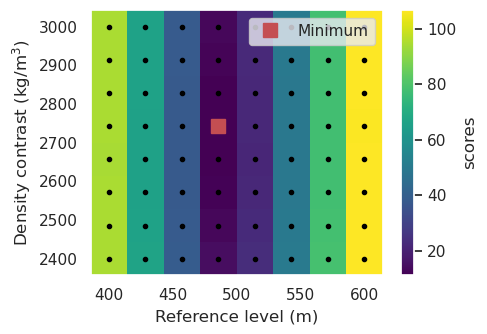

In [16]:
# Compare the scores and the damping values
plotting.plot_2_parameter_cv_scores(
    scores,
    parameter_pairs,
    param_names=("Reference level (m)", "Density contrast (kg/m$^3$)"),
    # logx=True,
    # logy=True,
    cmap="viridis",
)

## Run inversion with optimal damping, density and zref

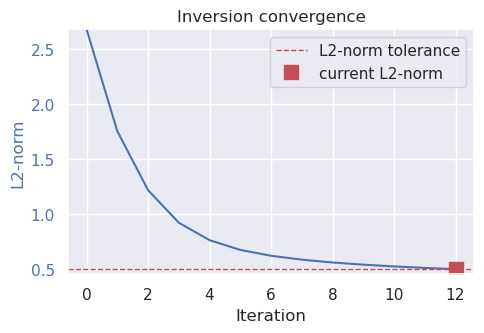

In [17]:
# set Python's logging level to get information about the inversion's progress
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
# logger.setLevel(logging.INFO)

# re-calculate density grid with the best density contrast and zref
density = xr.where(starting_topography >= best_zref, best_density, -best_density)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    best_zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# set regional misfit to 0
grav_df["reg"] = 0

# remove the regional from the misfit to get the residual
grav_df["res"] = grav_df.misfit - grav_df.reg

# update kwargs to pass to the inversion
kwargs["prism_layer"] = starting_prisms
kwargs["zref"] = best_zref
kwargs["density_contrast"] = best_density
kwargs["solver_damping"] = best_damping

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    # display the convergence of the inversion
    plot_dynamic_convergence=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

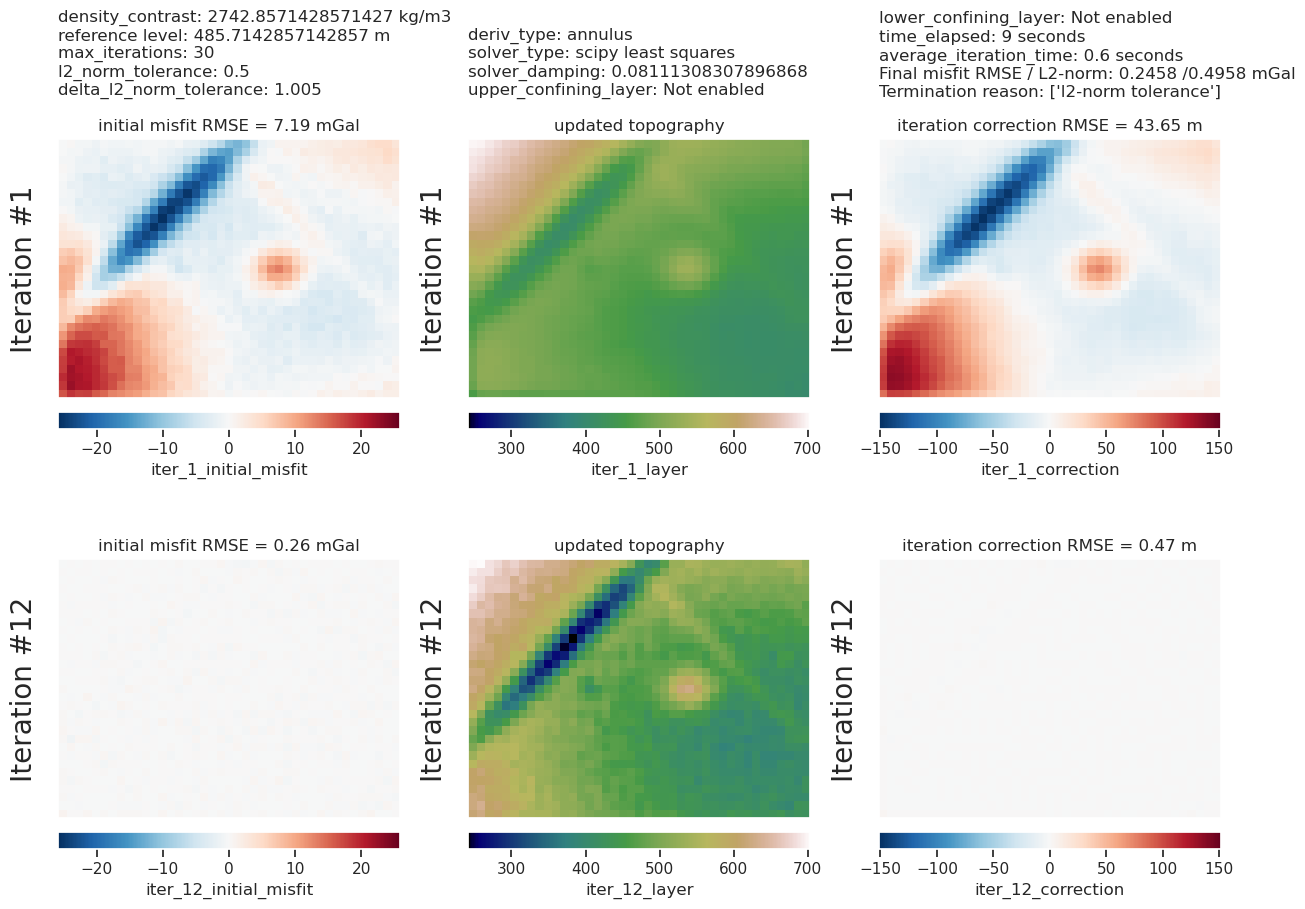

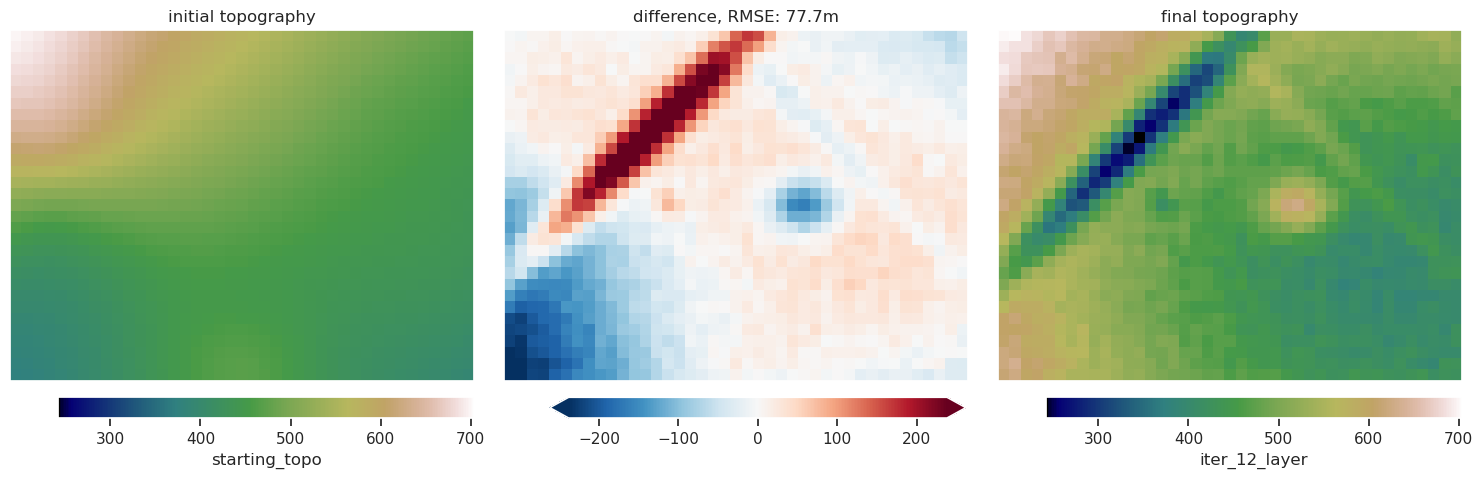

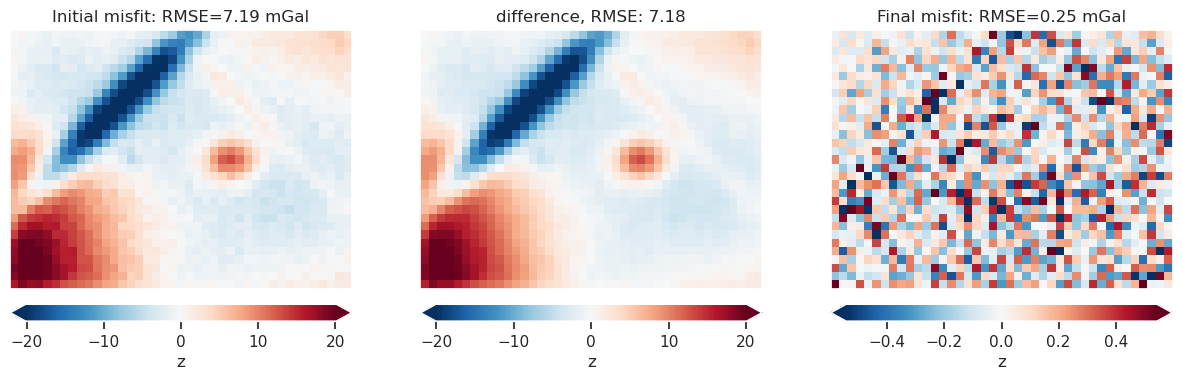

In [20]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

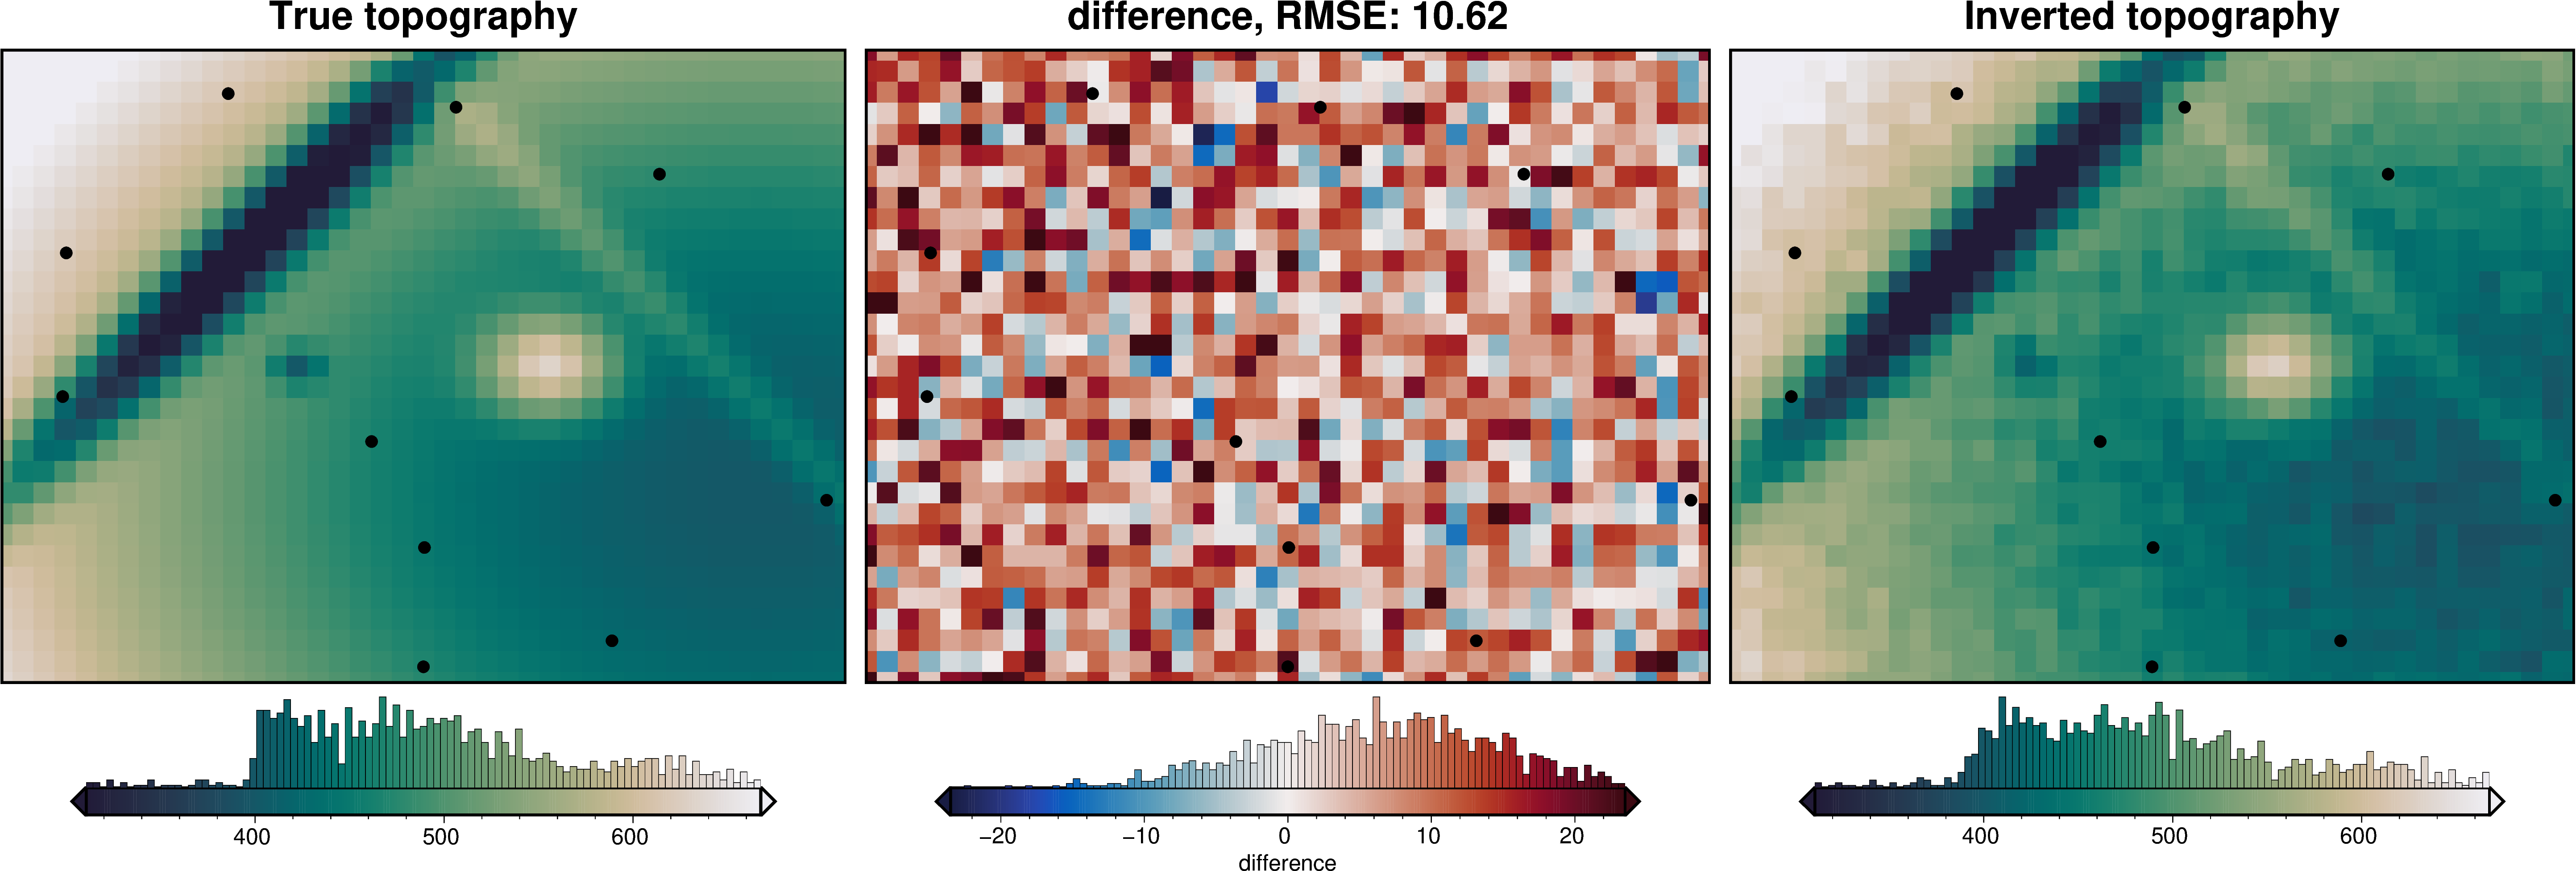

In [21]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

In [ ]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

## 6) Adhering to constraints: weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

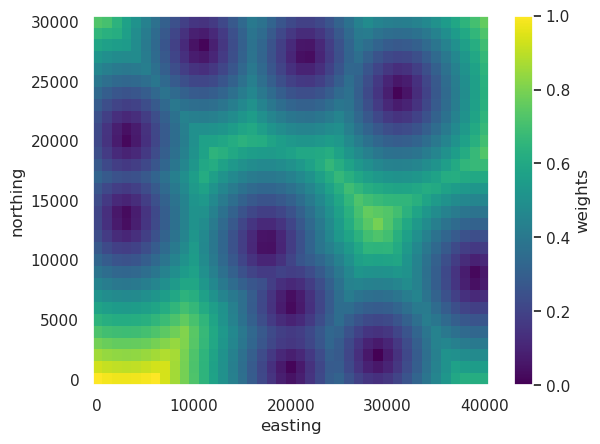

In [22]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
min_dist = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
starting_prisms["weights"] = min_dist
starting_prisms.weights.plot()

## Perform inversion
Now we can perform the inversion, suppying the argument `weights_after_solving=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. Note that we have increased the `max_iterations` from 30 to 100. This is because the weighting grid reduces the correction values at each iterations, resulting in the need for more iterations.

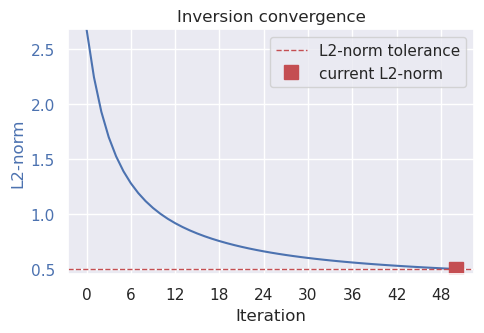

In [26]:
# update inversion kwargs
kwargs["weights_after_solving"] = True
kwargs["prism_layer"] = starting_prisms
kwargs["max_iterations"] = 100

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    # display the convergence of the inversion
    plot_dynamic_convergence=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

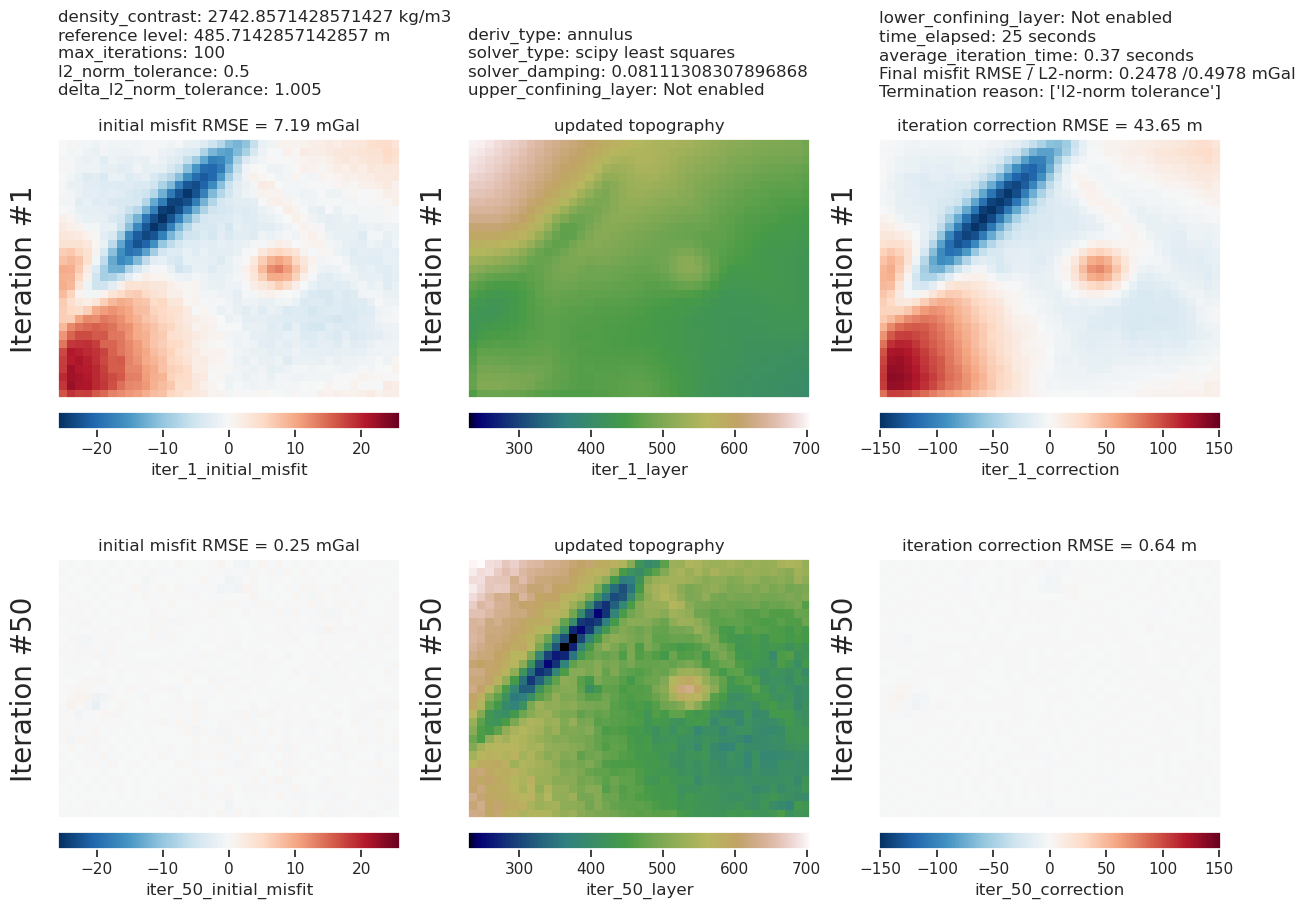

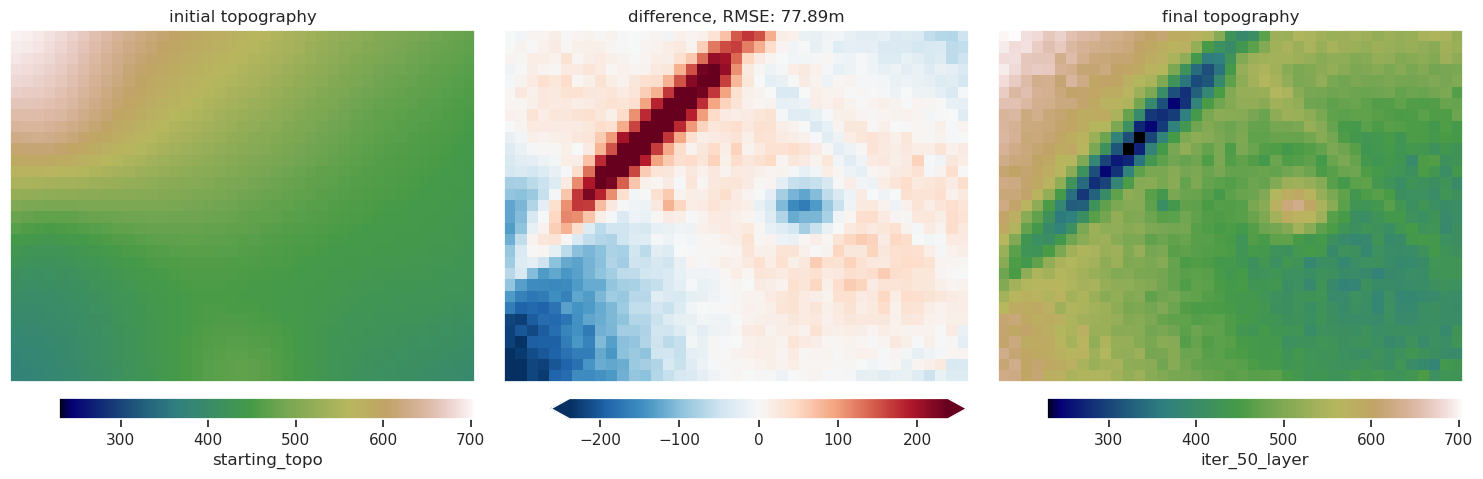

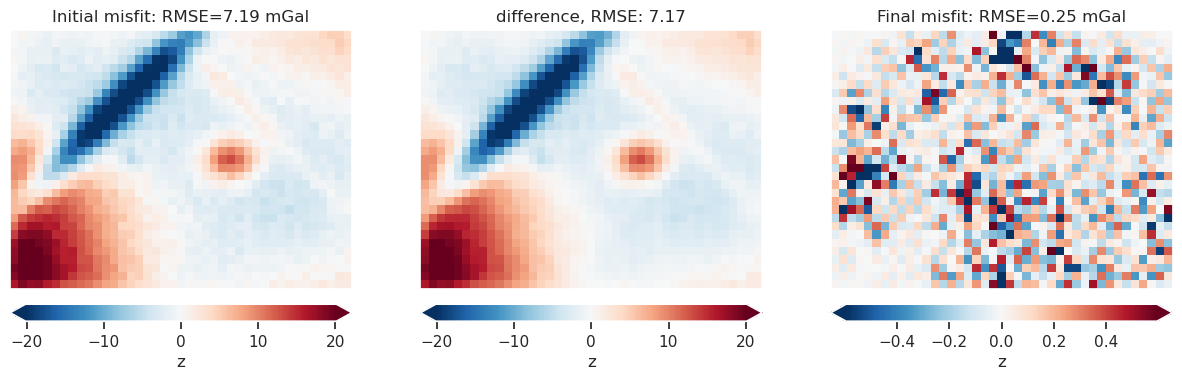

In [27]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

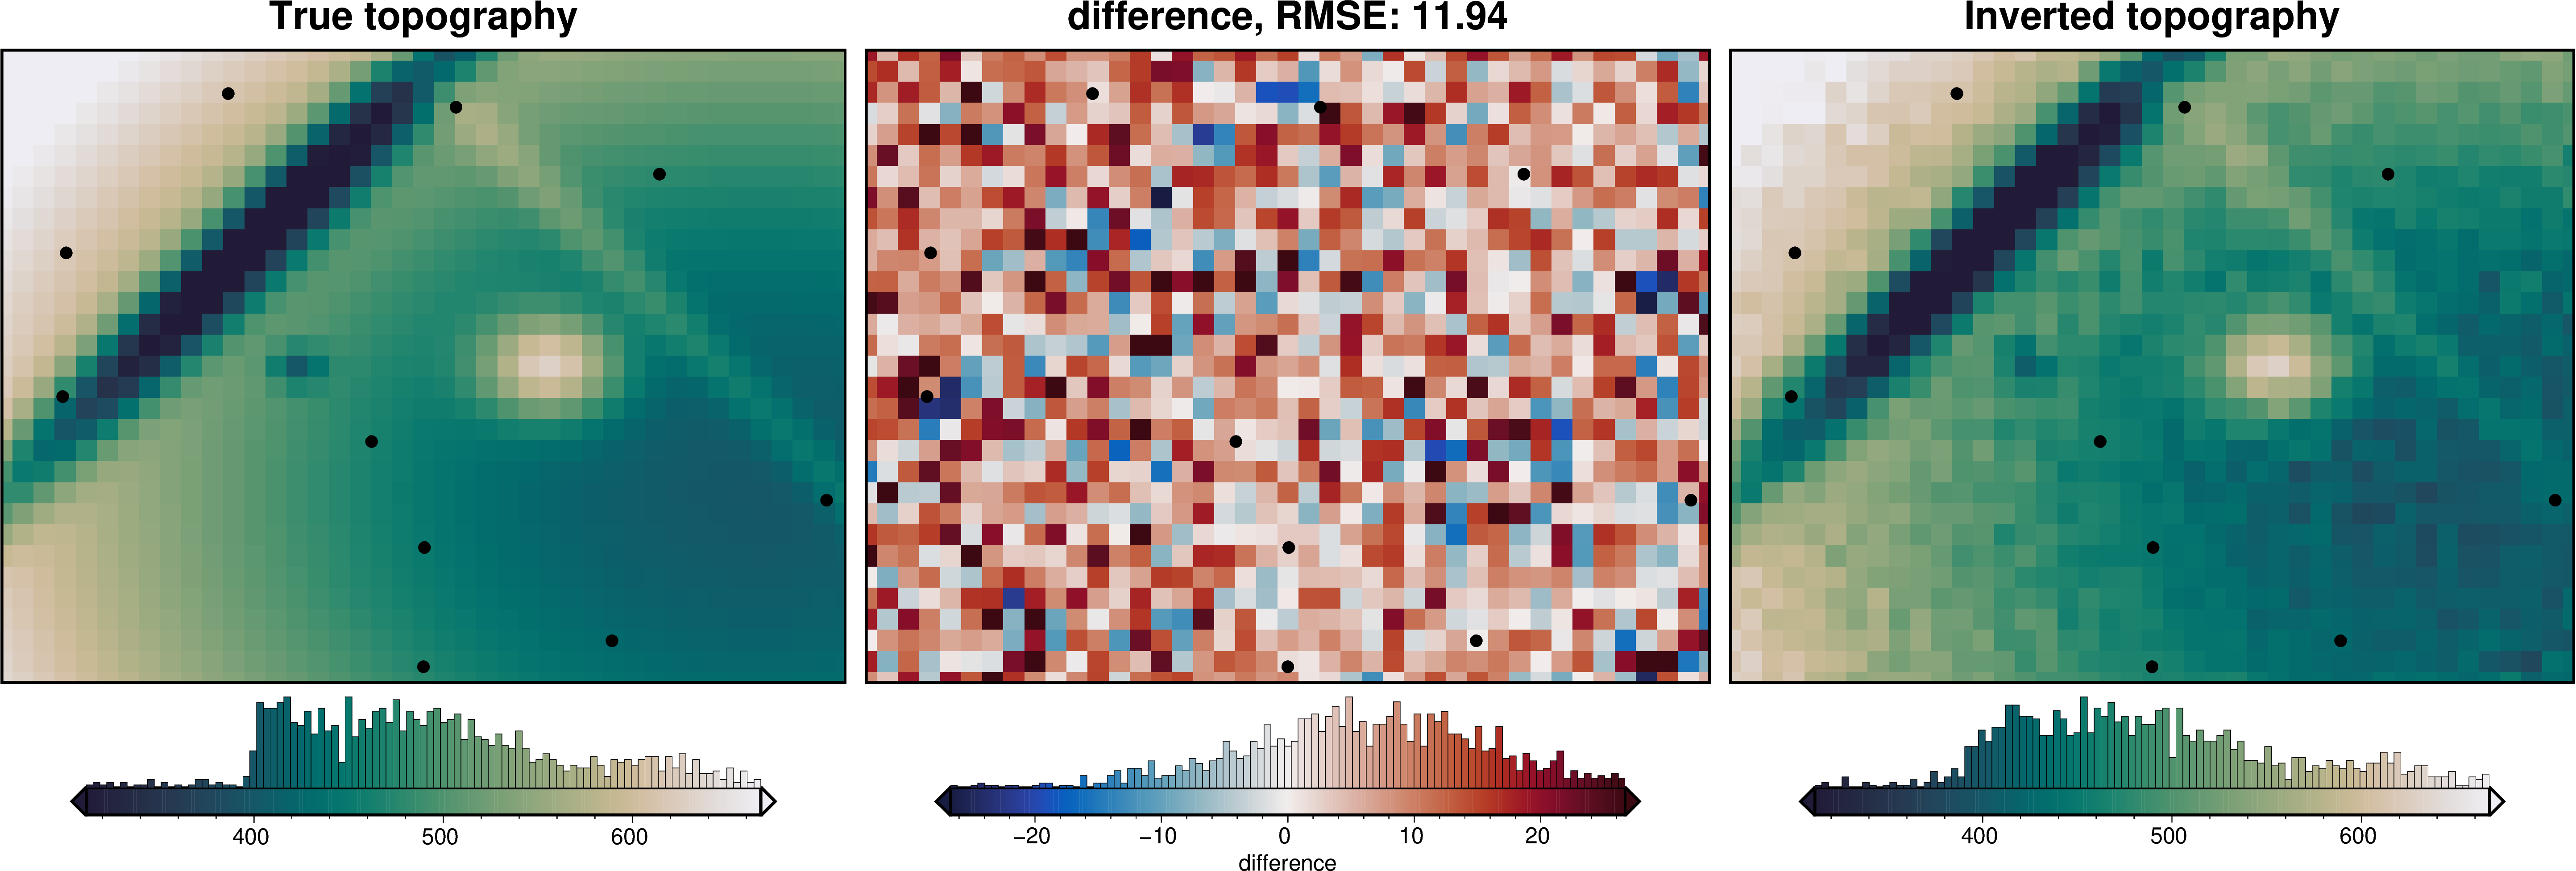

In [28]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

In [29]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 4.43 m


#